## INSTALLING DEPENDENCIES

In [ ]:
!pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym

In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 13.1 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


## IMPORT LIBRARIES

In [ ]:
import gym
import gym_anytrading
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf

## IMPORT DATASET

In [ ]:
df = yf.download('AAPL', start = '2019-01-01', end = '2020-01-01')
df.head()

# **1. USING ONLY OHLC DATA**

### 1.1. CREATE & RUN THE ENVIRONMENT

In [ ]:
env = gym.make('stocks-v0', df=df, frame_bound=(5,100), window_size=5)

In [ ]:
state = env.reset()
while True:
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done:
        print("info", info)
        break

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

### 1.2. TRAINING

In [ ]:
env_maker = lambda: gym.make()

In [ ]:
model = A2C('MlpLstmPolicy', env, verbose=1)
model.learn(total_timesteps=10000)

### 1.3.TESTING

In [ ]:
env = gym.make('stocks-v0', df=df, frame_bound=(90,110), window_size=5)
obs = env.reset()
while True:
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': -1.5574989318847656, 'total_profit': 0.9099781166839769, 'position': 0}


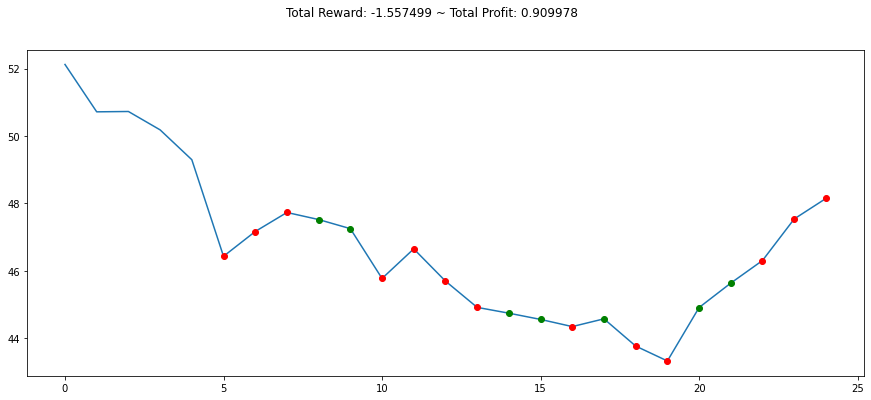

In [ ]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

# **2. USING INDICATORS**

###2.1. IMPORT LIBRARIES

In [ ]:
!pip install finta

### 2.2. CREATE INDICATOR COLUMNS

In [ ]:
from gym_anytrading.envs import StocksEnv
from finta import TA

In [ ]:
df1 = yf.download('AAPL', start = '2019-01-01', end = '2020-01-01')
df1['SMA'] = TA.SMA(df, 12)
df1['RSI'] = TA.RSI(df)
df1['OBV'] = TA.OBV(df)
df1.fillna(0, inplace=True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
df1.head()

,Open,High,Low,Close,Adj Close,Volume,SMA,RSI,OBV
Date,,,,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,38.326290,148158800,0.0,0.000000,0.0
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.508705,365248800,0.0,0.000000,-365248800.0
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.981857,234428400,0.0,29.357079,-130820400.0
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.901772,219111200,0.0,28.861016,-349931600.0
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.586174,164101200,0.0,38.434700,-185830400.0


### 2.2. CREATE ENVIRONMENT

In [ ]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [ ]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

env2 = MyCustomEnv(df=df1, window_size=12, frame_bound=(12,50))

### 2.2. TRAINING

In [ ]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [ ]:
model = A2C('MlpLstmPolicy', env, verbose=1)
model.learn(total_timesteps=1000000)

### 2.3. TESTING

In [ ]:
env = MyCustomEnv(df=df1, window_size=12, frame_bound=(80,250))
obs = env.reset()
while True:
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': 19.324989318847656, 'total_profit': 1.139735823259345, 'position': 0}


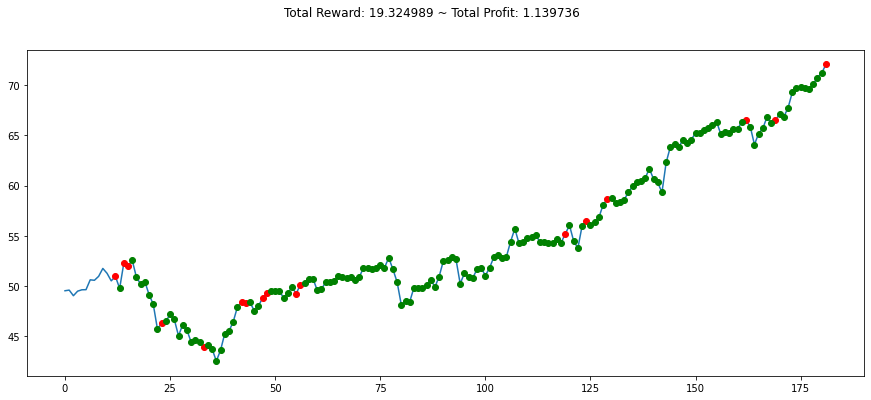

In [ ]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()